# Early Stopping and Pruning
    Controlling Overfitting and Compute During Model Training

## Objective

This notebook introduces early stopping and pruning as mechanisms to:

- Prevent overfitting during training

- Reduce unnecessary computation

- Accelerate hyperparameter optimization

- Improve generalization under limited budgets

It answers:

    How do we stop training and tuning models before they start to overfit or waste compute?

## Why Early Stopping and Pruning Matter

Unchecked training leads to:

Overfitting

- Wasted CPU/GPU time

- Slower experimentation cycles

- Increased operational costs

In production:

- Compute is finite

- Models must converge fast and safely

- Training must be interruptible and auditable

## Concepts Overview
Early Stopping

Stops model training when validation performance stops improving.

Pruning

Stops hyperparameter trials early when they are unlikely to outperform existing ones.

📌 They operate at different levels:

- Early stopping → model level

- Pruning → optimization level

## When to Use

| Scenario                    | Technique      |
| --------------------------- | -------------- |
| Gradient boosting           | Early stopping |
| Neural networks             | Early stopping |
| Bayesian optimization       | Pruning        |
| Large hyperparameter spaces | Pruning        |
| Limited compute             | Both           |

## Imports and Dataset

In [3]:
import numpy as np
import pandas as pd

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

In [22]:
df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv")

X = df.drop(columns=["default", "customer_id"])
y = df["default"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=2010
)

# MODELS

## Define Gradient Boosting Model

In [25]:
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)


### Train with Early Stopping

In [34]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    #early_stopping_rounds=30,
    verbose=False
)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

- ✔ Stops when validation AUC stops improving
- ✔ Restores best iteration automatically

## Evaluate Model

In [39]:
y_valid_prob = model.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, y_valid_prob)


np.float64(0.8960433989009114)

## Inspect Best Iteration

In [44]:
model.best_iteration

AttributeError: `best_iteration` is only defined when early stopping is used.

Often far below the initial n_estimators

## Why Early Stopping Works

- Prevents late-stage overfitting

- Acts as implicit regularization

- Reduces tuning burden

- Improves generalization stability

## Part II – Pruning (Optimization Level)

Pruning stops bad hyperparameter trials early.

## Define Optuna Objective with Pruning

In [47]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "eval_metric": "auc",
        "random_state": 42
    }

    model = XGBClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=20,
        verbose=False
    )

    y_valid_prob = model.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, y_valid_prob)

    trial.report(score, step=model.best_iteration)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return score


## Run Study with Pruner

In [50]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)

study.optimize(objective, n_trials=50)


[I 2026-02-02 11:01:57,512] A new study created in memory with name: no-name-206ccbd7-bbb2-44b5-ba6e-15777bd8b9bf
[W 2026-02-02 11:01:57,514] Trial 0 failed with parameters: {'n_estimators': 682, 'learning_rate': 0.036991151976841746, 'max_depth': 4, 'subsample': 0.655144721403713, 'colsample_bytree': 0.7492281467481224} because of the following error: TypeError("fit() got an unexpected keyword argument 'early_stopping_rounds'").
Traceback (most recent call last):
  File "C:\Users\pantu\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\pantu\AppData\Local\Temp\ipykernel_19460\2255291856.py", line 15, in objective
    model.fit(
  File "C:\Users\pantu\anaconda3\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'
[W 2026-02-02 11:01:57,518] Trial 0 failed with value None.


TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

Poor trials stop early
- Compute saved automatically

## Pruning Diagnostics

[W 2026-02-02 11:03:23,761] Study instance does not contain trials.


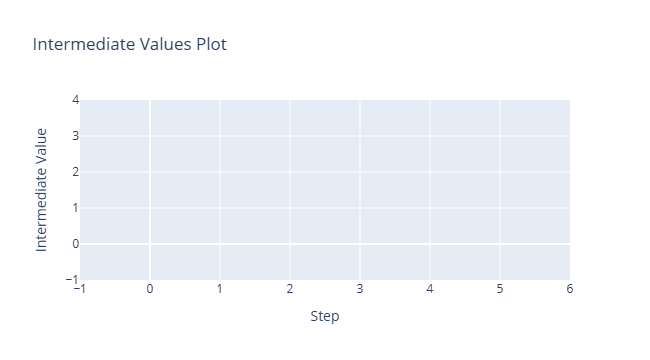

In [54]:
optuna.visualization.plot_intermediate_values(study)

[W 2026-02-02 11:03:32,109] There are no complete trials.


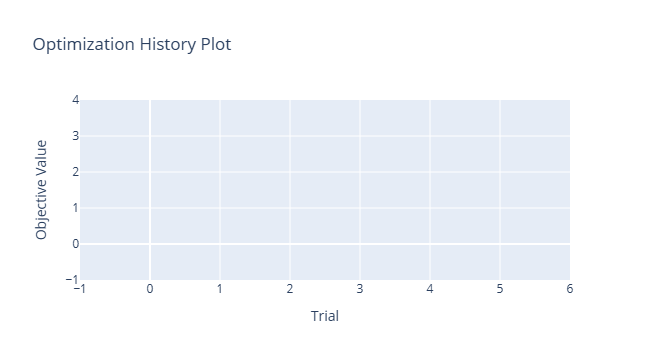

In [56]:
optuna.visualization.plot_optimization_history(study)

[W 2026-02-02 11:03:38,394] There are no complete trials.


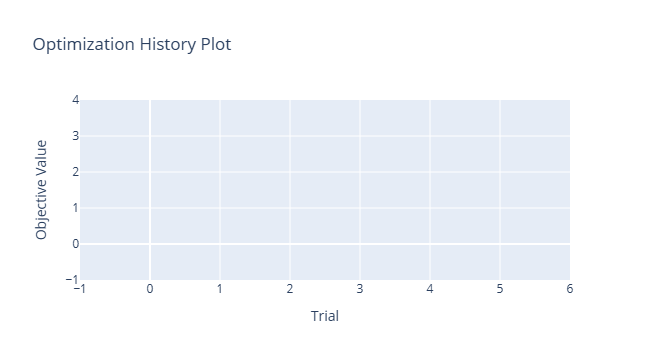

In [58]:
optuna.visualization.plot_optimization_history(study)

## Early Stopping vs Pruning

| Aspect    | Early Stopping      | Pruning               |
| --------- | ------------------- | --------------------- |
| Scope     | Single model        | Optimization process  |
| Stops     | Training iterations | Hyperparameter trials |
| Prevents  | Overfitting         | Wasted compute        |
| Used With | Boosting, NN        | Bayesian optimization |


## Common Mistakes (Avoided)

- ❌ No validation set
- ❌ Using test set for early stopping
- ❌ Too aggressive patience
- ❌ Pruning without warm-up
- ❌ Ignoring best iteration

## Key Takeaways

Early stopping is mandatory for boosting models

Pruning dramatically reduces tuning time

Validation data is non-negotiable

These techniques are production-critical

Together, they enable scalable ML systems

## End of Chapter

You have now completed:

[07_Model_Tuning_and_Optimization/]()

├── [01_grid_search.ipynb](01_grid_search.ipynb)

├── [02_randomized_search.ipynb](02_randomized_search.ipynb)

├── [03_bayesian_optimization.ipynb](03_bayesian_optimization.ipynb)

└── [04_early_stopping_and_pruning.ipynb](04_early_stopping_and_pruning.ipynb)